In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [5]:
exp_ids=['2018_06_28_10_02_51_Microwave RFE',
         '2018_06_28_10_18_49_Microwave RFE',
         '2018_06_28_10_32_41_Microwave RFE'
        ]

assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_28/2018_06_28_10_02_51_Microwave RFE/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_28/2018_06_28_10_18_49_Microwave RFE/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_28/2018_06_28_10_32_41_Microwave RFE/qdp.txt


# Experiment-wise analysis

<IPython.core.display.Javascript object>


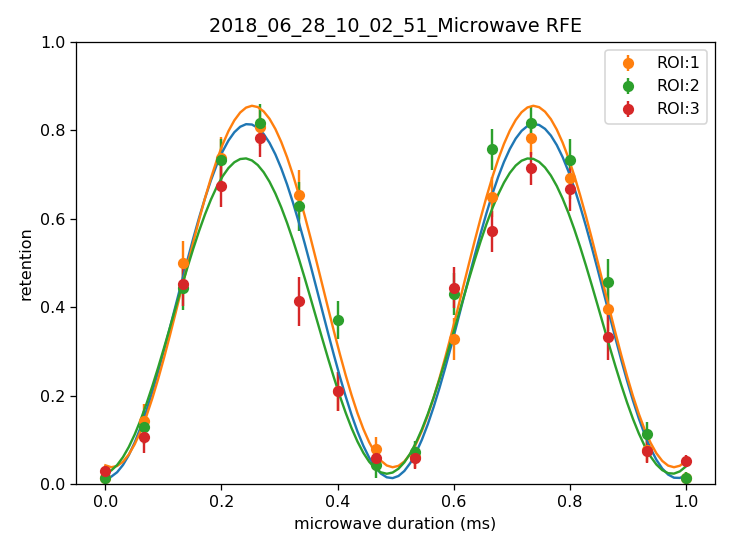

amplitude: 0.400660440131 , freq: 2.02886905781 kHz, t-pi : 0.2464427155 ms 
amplitude: 0.408857625575 , freq: 2.064427483 kHz, t-pi : 0.242197899475 ms 
amplitude: 0.356792677025 , freq: 2.0362082952 kHz, t-pi : 0.245554446064 ms 


<IPython.core.display.Javascript object>


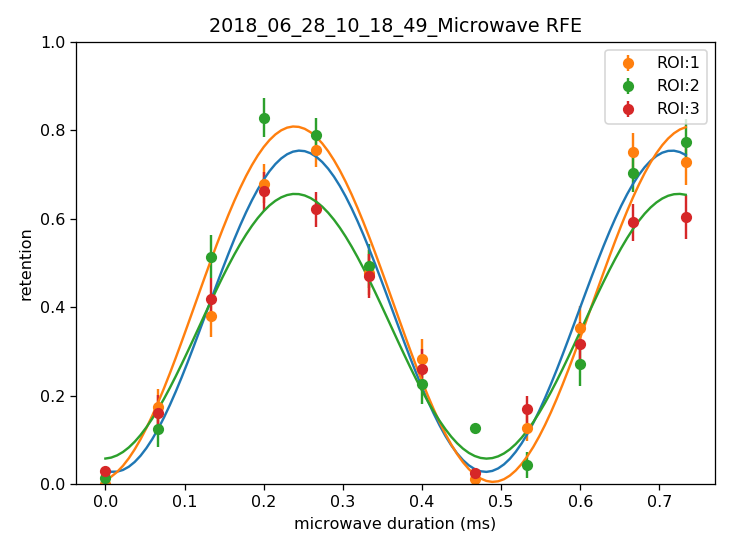

amplitude: 0.363418044964 , freq: 2.12713488197 kHz, t-pi : 0.235057966582 ms 
amplitude: 0.402048847885 , freq: 1.99274937578 kHz, t-pi : 0.250909625704 ms 
amplitude: 0.29946145013 , freq: 2.0646869518 kHz, t-pi : 0.242167462512 ms 


<IPython.core.display.Javascript object>


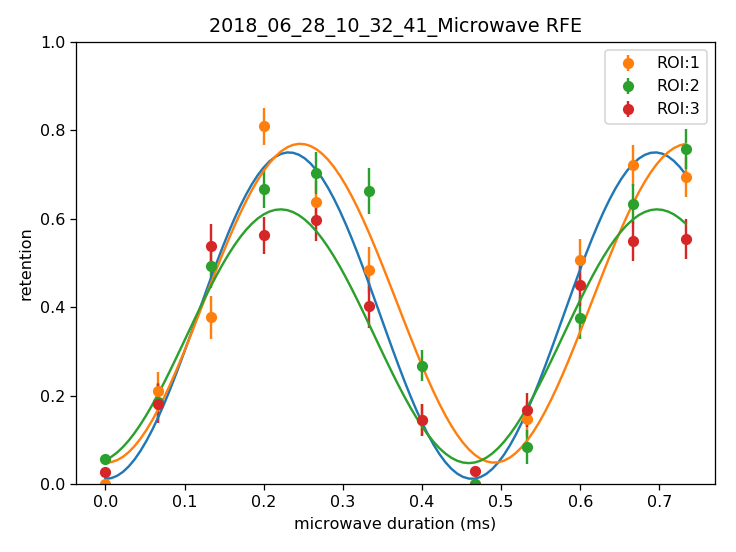

amplitude: 0.369257375065 , freq: 2.16190468511 kHz, t-pi : 0.231277541255 ms 
amplitude: 0.36066891367 , freq: 2.03914877687 kHz, t-pi : 0.245200353045 ms 
amplitude: 0.287039642366 , freq: 2.10272243885 kHz, t-pi : 0.237786971196 ms 


In [6]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
savefig=False
for i in range(0,len(exp_ids)):
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()

    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.4, 2, 0, 0.5]
    fitted_parameters=[]
    for roi in [1,2,3]:
        error=0
        data = []
        reten = []
        err = []
        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        try:
            #sin(t,amp,freq,phase,offset)
            fit,pcov = curve_fit(sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
        except RuntimeError:
            error=1
        if error is not 1:
            print "amplitude: {} , freq: {} kHz, t-pi : {} ms ".format(fit[0],fit[1],0.5/fit[1])
 
            xarray=np.linspace(np.min(data),np.max(data),100)
            yfit=sin(xarray, fit[0], fit[1], fit[2], fit[3])
            plt.plot(xarray,yfit)
            if roi==2:
                assorted_roi2freqs.append(fit[1])

    plt.show()
    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    if savefig:
        plt.savefig('{}.pdf'.format(exp_id))

In [8]:
print np.mean([0.231277541255, 0.245200353045])

0.23823894715


# Overlaid

In [6]:
(3.02/1.9)**2

2.526426592797784